In [1]:
import os
# import colabdesign
# from colabdesign.mpnn import mk_mpnn_model, clear_mem
# from colabdesign.shared.protein import pdb_to_string
os.chdir('/home/jupyter-yehlin/DMSV2/pairwise_final/')
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import tqdm.notebook
import seaborn
import re, tempfile
# from colabdesign.af.contrib import predictz
# from colabdesign.shared.protein import _np_rmsd

if "hhsuite" not in os.environ['PATH']:
    os.environ['PATH'] += ":/home/jupyter-yehlin/DMSV2/pairwise_final"
    
    
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr
import shutil
import random

In [2]:
def parse_PDB_biounits(x, atoms=["N", "CA", "C", "O", "CB", "CG", "CD1", "CD2", "CE2", "CE3", "NE1", "CZ2", "CZ3", "CH2"], chain='A'):
  '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, atoms, coords=(x,y,z)), sequence
  '''

  alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
  states = len(alpha_1)
  alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
             'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','GAP']
  
  aa_1_N = {a:n for n,a in enumerate(alpha_1)}
  aa_3_N = {a:n for n,a in enumerate(alpha_3)}
  aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
  aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
  aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}
  
  def AA_to_N(x):
    # ["ARND"] -> [[0,1,2,3]]
    x = np.array(x);
    if x.ndim == 0: x = x[None]
    return [[aa_1_N.get(a, states-1) for a in y] for y in x]
  
  def N_to_AA(x):
    # [[0,1,2,3]] -> ["ARND"]
    x = np.array(x);
    if x.ndim == 1: x = x[None]
    return ["".join([aa_N_1.get(a,"-") for a in y]) for y in x]

  xyz,seq,min_resn,max_resn = {},{},1e6,-1e6
  for line in open(x,"rb"):
    line = line.decode("utf-8","ignore").rstrip()

    if line[:6] == "HETATM" and line[17:17+3] == "MSE":
      line = line.replace("HETATM","ATOM  ")
      line = line.replace("MSE","MET")

    if line[:4] == "ATOM":
      ch = line[21:22]
      if ch == chain or chain is None:
        atom = line[12:12+4].strip()
        resi = line[17:17+3]
        resn = line[22:22+5].strip()
        x,y,z = [float(line[i:(i+8)]) for i in [30,38,46]]

        if resn[-1].isalpha(): 
            resa,resn = resn[-1],int(resn[:-1])-1
        else: 
            resa,resn = "",int(resn)-1
#         resn = int(resn)
        if resn < min_resn: 
            min_resn = resn
        if resn > max_resn: 
            max_resn = resn
        if resn not in xyz: 
            xyz[resn] = {}
        if resa not in xyz[resn]: 
            xyz[resn][resa] = {}
        if resn not in seq: 
            seq[resn] = {}
        if resa not in seq[resn]: 
            seq[resn][resa] = resi

        if atom not in xyz[resn][resa]:
          xyz[resn][resa][atom] = np.array([x,y,z])

  # convert to numpy arrays, fill in missing values
  seq_,xyz_ = [],[]
  try:
      for resn in range(min_resn,max_resn+1):
        if resn in seq:
          for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k],20))
        else: seq_.append(20)
        if resn in xyz:
          for k in sorted(xyz[resn]):
            for atom in atoms:
              if atom in xyz[resn][k]: xyz_.append(xyz[resn][k][atom])
              else: xyz_.append(np.full(3,np.nan))
        else:
          for atom in atoms: xyz_.append(np.full(3,np.nan))
      return np.array(xyz_).reshape(-1,len(atoms),3), N_to_AA(np.array(seq_))
  except TypeError:
      return 'no_chain', 'no_chain'



In [3]:
order = "ACDEFGHIKLMNPQRSTVWYX"
amino_acid_to_number = {aa: i for i, aa in enumerate(order)}

def get_pairs_single(S, contact_pairwise_index):
    index_1 = contact_pairwise_index[:, 0].astype(np.int64)
    index_2 = contact_pairwise_index[:, 1].astype(np.int64)
    
    wt_1 = S[index_1]

    wt_2 = S[index_2]

    wt_pairwise = (wt_1 * 21) + wt_2
    
    true_pairwise = wt_pairwise.flatten()

    true_pairwise_count = np.bincount(true_pairwise).astype(int)

    return true_pairwise_count

def calculate_contacts_and_get_pairwise(xyz, seq, distance_threshold=3, pairwise_threshold=6):

    dict_coord = {}  # dict to store coordinates. dict_coord[res][atom] = (x, y, z)
    contacting_pairs = []  # List to store pairs of contacting residues as [ires, jres]

    # Precompute distance threshold squared
    distance_threshold_sq = distance_threshold ** 2

    for i, (xyz, res) in enumerate(zip(xyz, seq)):
        for atom_num, coords in enumerate(xyz):
            if not np.isnan(coords).any():  # Skip atoms with NaN coordinates
                x, y, z = coords
                res = i + 1  # Numeric index for the residue
                if res not in dict_coord:
                    dict_coord[res] = []
                dict_coord[res].append((x, y, z))

    res_list = list(dict_coord.keys())
    res_coords = [np.array(dict_coord[res]) for res in res_list]

    for i, ires_coords in enumerate(res_coords):
        for j in range(i + 1, len(res_list)):
            jres_coords = res_coords[j]
            distances = np.sum((ires_coords[:, np.newaxis] - jres_coords) ** 2, axis=-1)
            close_atoms = np.argwhere(distances < distance_threshold_sq)
            if close_atoms.size > 0 and abs(i-j)>=6:
                contacting_pairs.append([res_list[i]-1, res_list[j]-1])
                
                
    S = np.array([amino_acid_to_number[aa] for aa in seq])
    contacting_pairs= np.array(contacting_pairs)
    test_true_pairs = np.zeros(441, dtype=int)
    true_pairwise_count = get_pairs_single(S, contacting_pairs)
    test_true_pairs[:len(true_pairwise_count)] += true_pairwise_count

    return test_true_pairs, contacting_pairs

## pairwise analysis within 5A

In [4]:
import re
import ast
import pandas as pd

def fix_list_str(input_str):
    # Add commas between numbers
    fixed_str = re.sub(r'(\d+)', r'\1, ', input_str)
    # Add brackets and convert to a list
    return ast.literal_eval(f"[{fixed_str}]")

df = pd.read_csv('pairwise_counts_native_between_0A_5A_atom37.csv')
df['pairwise_count'] = df['pairwise_count'].apply(fix_list_str)

In [5]:
df_3A_decoy_native = pd.read_csv('native_decoys_pairwise_counts_native_between_0A_3A_atom37.csv')
df_3A_decoy_native['pairwise_count'] = df_3A_decoy_native['pairwise_count'].apply(fix_list_str)

df_5A_decoy_native = pd.read_csv('native_decoys_pairwise_counts_native_between_0A_5A_atom37.csv')
df_5A_decoy_native['pairwise_count'] = df_5A_decoy_native['pairwise_count'].apply(fix_list_str)

df_3A = pd.read_csv('pairwise_counts_native_between_0A_3A_atom37.csv')
df_3A['pairwise_count'] = df_3A['pairwise_count'].apply(fix_list_str)
df_10A = pd.read_csv('pairwise_counts_native_between_5A_10A_atom37.csv')
df_10A['pairwise_count'] = df_10A['pairwise_count'].apply(fix_list_str)

Exception ignored in: <function _xla_gc_callback at 0x7f0b840dcf70>
Traceback (most recent call last):
  File "/home/jupyter-yehlin/.local/lib/python3.9/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
merged_df = pd.merge(df, df_3A[['name', 'pairwise_count']], on='name', how='left')
merged_df = merged_df.rename(columns={'pairwise_count_x': 'pairwise_count_5A', 'pairwise_count_y': 'pairwise_count_3A'})
merged_df = pd.merge(merged_df, df_10A[['name', 'pairwise_count']], on='name', how='left')
merged_df = merged_df.rename(columns={'pairwise_count': 'pairwise_count_10A'})

In [8]:
methods = {"TrROS":{},"TrMRF":{},"TrROS_Hall":{},"JUSTAS":{}}

In [57]:
filtered_df_1 = merged_df[merged_df['name'].str.contains('TrROS_unrelaxed')]
chain_id_counts_1 = filtered_df_1['name'].value_counts()
print(len(chain_id_counts_1))

filtered_df_2 = merged_df[merged_df['name'].str.contains('TrMRF_unrelaxed')]
chain_id_counts_2 = filtered_df_2['name'].value_counts()
print(len(chain_id_counts_2))

filtered_df_3 = merged_df[merged_df['name'].str.contains('TrROS_Hall_unrelaxed')]
chain_id_counts_3 = filtered_df_3['name'].value_counts()
print(len(chain_id_counts_3))

filtered_df_4 = merged_df[df['name'].str.contains('JUSTAS_unrelaxed')]
chain_id_counts_4 = filtered_df_4['name'].value_counts()
print(len(chain_id_counts_4))

df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3, filtered_df_4])
df.reset_index(drop=True, inplace=True)

5874
5874
5874
5874


In [58]:
df = df.drop_duplicates(subset=['name'])

protein_dict = {}

for protein_id in df['name']:
    tmp = protein_id.split("_")
    prefix, method = "_".join(tmp[:2]), "_".join(tmp[2:])
    if prefix in protein_dict:
        protein_dict[prefix].append(protein_id)
    else:
        protein_dict[prefix] = [protein_id]

filtered_protein_dict = {key: value for key, value in protein_dict.items() if len(value) == 4}

filtered_proteins = [protein for proteins in filtered_protein_dict.values() for protein in proteins]

df = df[df['name'].isin(filtered_proteins)]

In [59]:
filtered_df_1 = df[df['name'].str.contains('TrROS_unrelaxed')]
chain_id_counts_1 = filtered_df_1['name'].value_counts()
print(len(chain_id_counts_1))

filtered_df_2 = df[df['name'].str.contains('TrMRF_unrelaxed')]
chain_id_counts_2 = filtered_df_2['name'].value_counts()
print(len(chain_id_counts_2))

filtered_df_3 = df[df['name'].str.contains('TrROS_Hall_unrelaxed')]
chain_id_counts_3 = filtered_df_3['name'].value_counts()
print(len(chain_id_counts_3))

filtered_df_4 = df[df['name'].str.contains('JUSTAS_unrelaxed')]
chain_id_counts_4 = filtered_df_4['name'].value_counts()
print(len(chain_id_counts_4))

df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3, filtered_df_4])
df.reset_index(drop=True, inplace=True)

5874
5874
5874
5874


In [60]:
decoy_native_pairwise_count = [item[0] if isinstance(item, (list, tuple)) else item for item in df_5A_decoy_native['pairwise_count'].tolist()]
decoy_native = np.array(np.sum(decoy_native_pairwise_count, axis=0)).reshape(21,21)

In [61]:
pairwise_count_1=[item[0] for item in filtered_df_1['pairwise_count_5A'].tolist()]
pairwise_count_2=[item[0] for item in filtered_df_2['pairwise_count_5A'].tolist()]
pairwise_count_3=[item[0] for item in filtered_df_3['pairwise_count_5A'].tolist()]
pairwise_count_4=[item[0] for item in filtered_df_4['pairwise_count_5A'].tolist()]

In [62]:
import numpy as np
result1 = np.array(np.sum(pairwise_count_1, axis=0)).reshape(21,21)
result2 = np.array(np.sum(pairwise_count_2, axis=0)).reshape(21,21)
result3 = np.array(np.sum(pairwise_count_3, axis=0)).reshape(21,21)
result4 = np.array(np.sum(pairwise_count_4, axis=0)).reshape(21,21)

In [63]:
print("TrROS", np.sum(result1))
print("TrMRF", np.sum(result2))
print("TrROS_Hall", np.sum(result3))
print("JUSTAS", np.sum(result4))

TrROS 556640
TrMRF 569810
TrROS_Hall 567971
JUSTAS 539384


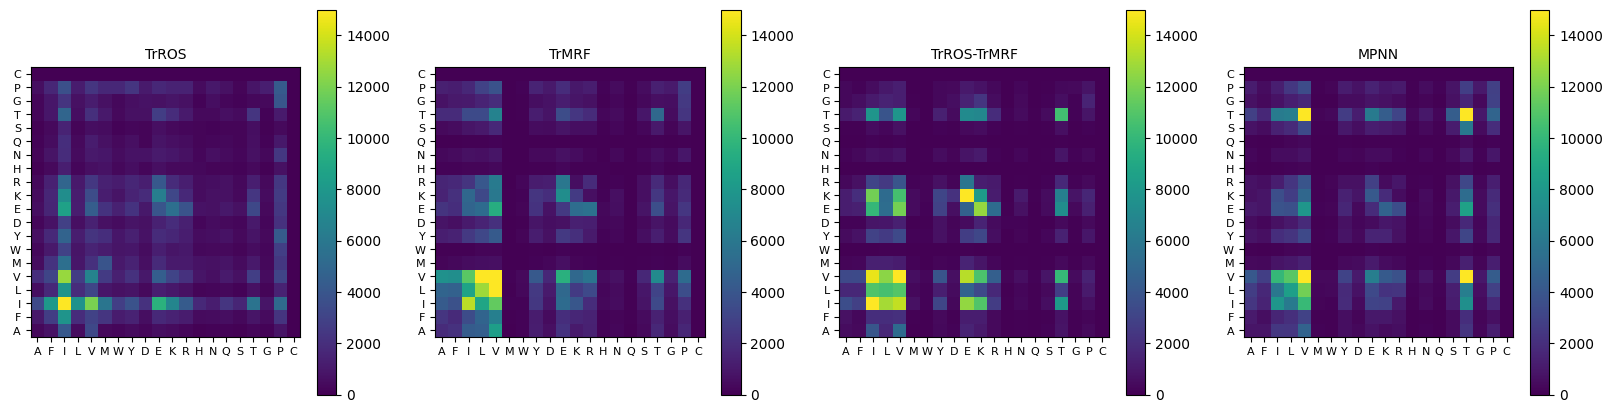

In [64]:
import numpy as np
import matplotlib.pyplot as plt

original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'AFILVMWYDEKRHNQSTGPC'

order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}
def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):

    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    img = ax.imshow(reordered_matrix, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)

    return plt



fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=15000)

# Plot for result2
plot_reordered_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=15000)

# Plot for result3
plot_reordered_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF", vmin=0, vmax=15000)

# Plot for result4
plot_reordered_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN", vmin=0, vmax=15000)

plt.savefig('figures/contact_pairs/d<5_counts.png', dpi=300)
plt.show()

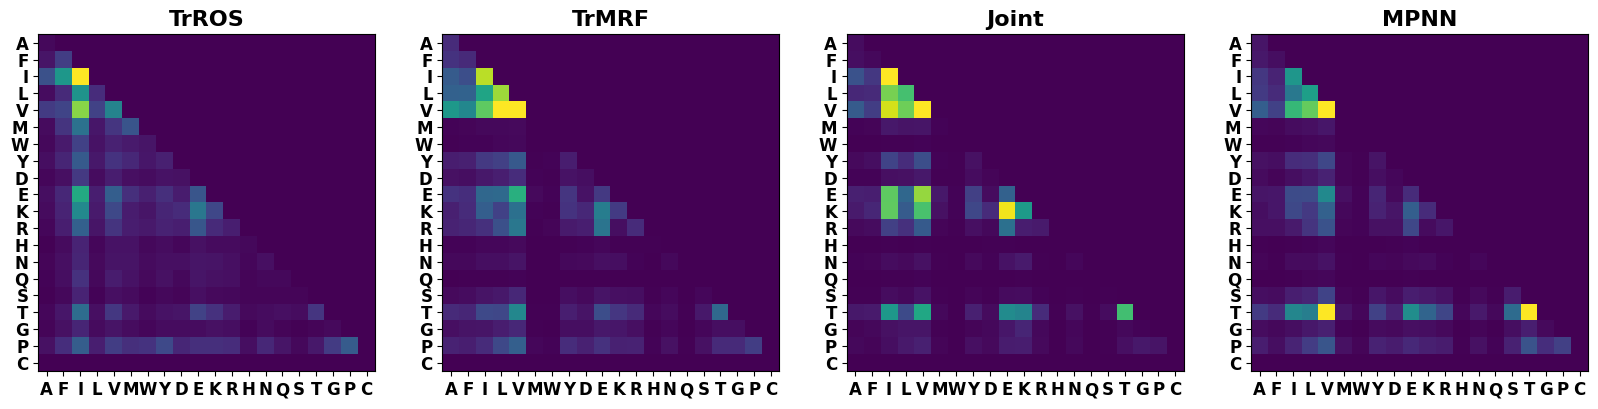

In [67]:
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'AFILVMWYDEKRHNQSTGPC'

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None, colorbar=False):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]


    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    if colorbar == True:
        cbar = plt.colorbar(img, format="%d", ax=ax)
        cbar.ax.set_ylabel('Colorbar Label', fontsize=12, weight='bold')
        for l in cbar.ax.yaxis.get_ticklabels():
            l.set_weight("bold")
            l.set_fontsize(12)

    ax.set_title(title, fontsize=16, weight = 'bold')

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')



    return folded_matrix

fig, axs = plt.subplots(1, 4, figsize=(20, 5))




folded_matrix_1= plot_reordered_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=30000)
folded_matrix_2 = plot_reordered_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=30000)
folded_matrix_3= plot_reordered_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "Joint", vmin=0, vmax=30000)
folded_matrix_4= plot_reordered_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN",  vmin=0, vmax=30000)
plt.savefig('/home/jupyter-yehlin/DMSV2/figures/contact_pairs/d<5_counts_diagonal.png', dpi=300)
plt.show()

In [68]:
folded_matrix_decoy_native= plot_reordered_matrix(axs[0],np.array(np.sum(decoy_native_pairwise_count, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=30000)

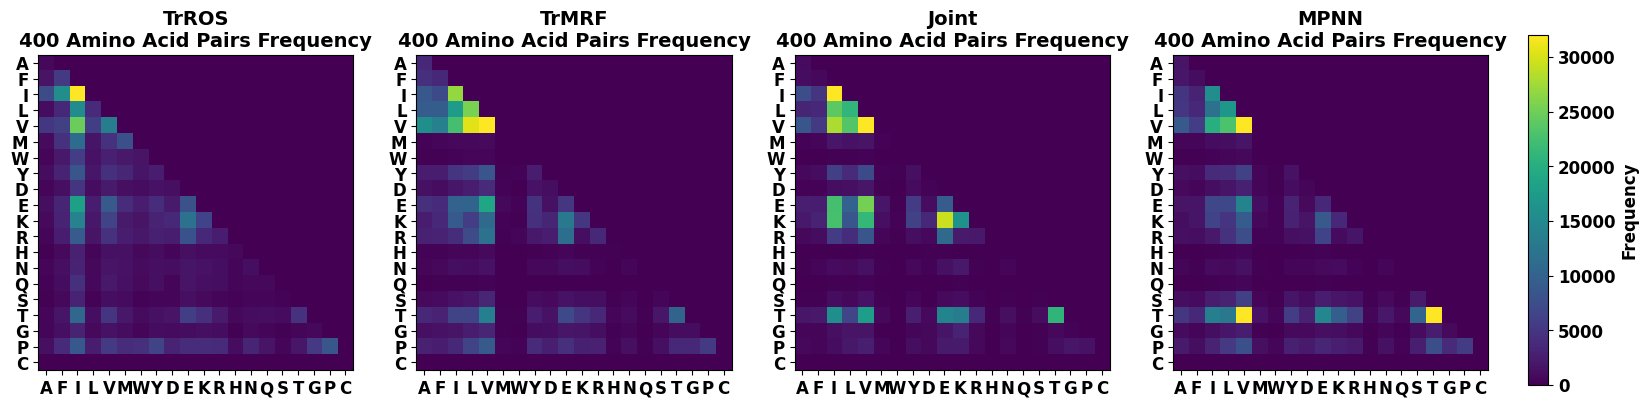

In [69]:
import numpy as np
import matplotlib.pyplot as plt

original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'AFILVMWYDEKRHNQSTGPC'

order_mapping = {amino_acid: i for i, amino_acid in enumerate(original_order)}

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 21st row and column
    matrix = result_matrix[:20, :20]

    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j, i] = reordered_matrix[i, j] + reordered_matrix[j, i]

    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=14, weight='bold')

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')

    return img  # Return the image object for colorbar handling

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

img1 = plot_reordered_matrix(axs[0], np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS\n400 Amino Acid Pairs Frequency", vmin=0, vmax=32000)
img2 = plot_reordered_matrix(axs[1], np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF\n400 Amino Acid Pairs Frequency", vmin=0, vmax=32000)
img3 = plot_reordered_matrix(axs[2], np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "Joint\n400 Amino Acid Pairs Frequency", vmin=0, vmax=32000)
img4 = plot_reordered_matrix(axs[3], np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN\n400 Amino Acid Pairs Frequency", vmin=0, vmax=32000)


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])  
cbar = fig.colorbar(img4, cax=cbar_ax)  
cbar.ax.set_ylabel('Frequency', fontsize=12, weight='bold')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    l.set_fontsize(12)


plt.savefig('figures/contact_pairs/d<5_counts_diagonal_title.png', dpi=300)
plt.show()

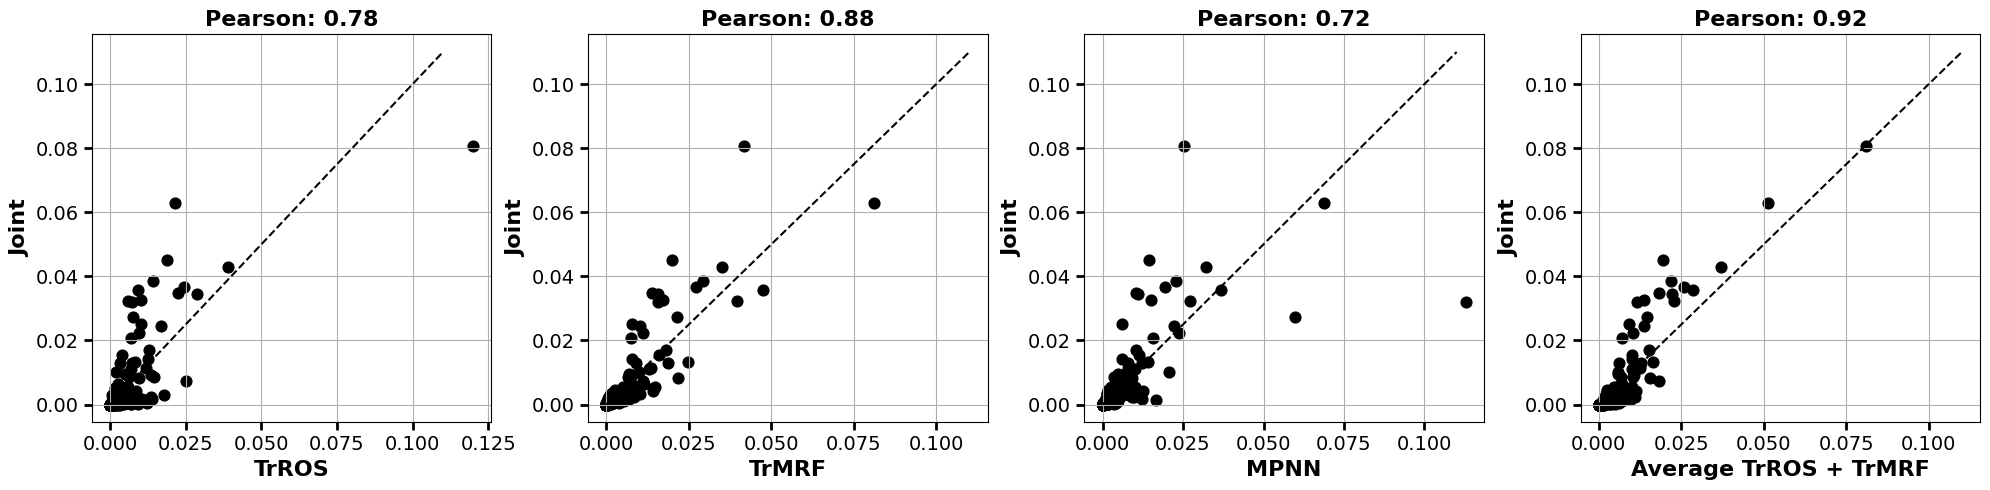

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


A=folded_matrix_1.flatten()/np.sum(folded_matrix_1)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)

min_val = 0
max_val = 0.11

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].scatter(A, B, color='black' , s = 60)
axes[0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[0].set_title("Pearson: {:.2f}".format(pearson_corr),fontsize = 16, weight = "bold")
axes[0].set_xlabel("TrROS",fontsize = 16, weight = "bold")
axes[0].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[0].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[0].grid(True)

A=folded_matrix_2.flatten()/np.sum(folded_matrix_2)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)


axes[1].scatter(A, B, color='black', s = 60)
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[1].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[1].set_xlabel("TrMRF",fontsize = 16, weight = "bold")
axes[1].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[1].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[1].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[1].grid(True)



A=folded_matrix_4.flatten()/np.sum(folded_matrix_4)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)


axes[2].scatter(A, B, color='black', s = 60)
axes[2].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[2].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[2].set_xlabel("MPNN",fontsize = 16, weight = "bold")
axes[2].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[2].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[2].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[2].grid(True)


A=(folded_matrix_1.flatten()/np.sum(folded_matrix_1) + folded_matrix_2.flatten()/np.sum(folded_matrix_2))/2
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)


axes[3].scatter(A, B, color='black' , s = 60)
axes[3].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[3].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[3].set_xlabel("Average TrROS + TrMRF",fontsize = 16, weight = "bold")
axes[3].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[3].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[3].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[3].grid(True)

plt.tight_layout()
plt.savefig('figures/contact_pairs/d<5_counts_diagonal_scatter_plot.png', dpi=300)

plt.show()

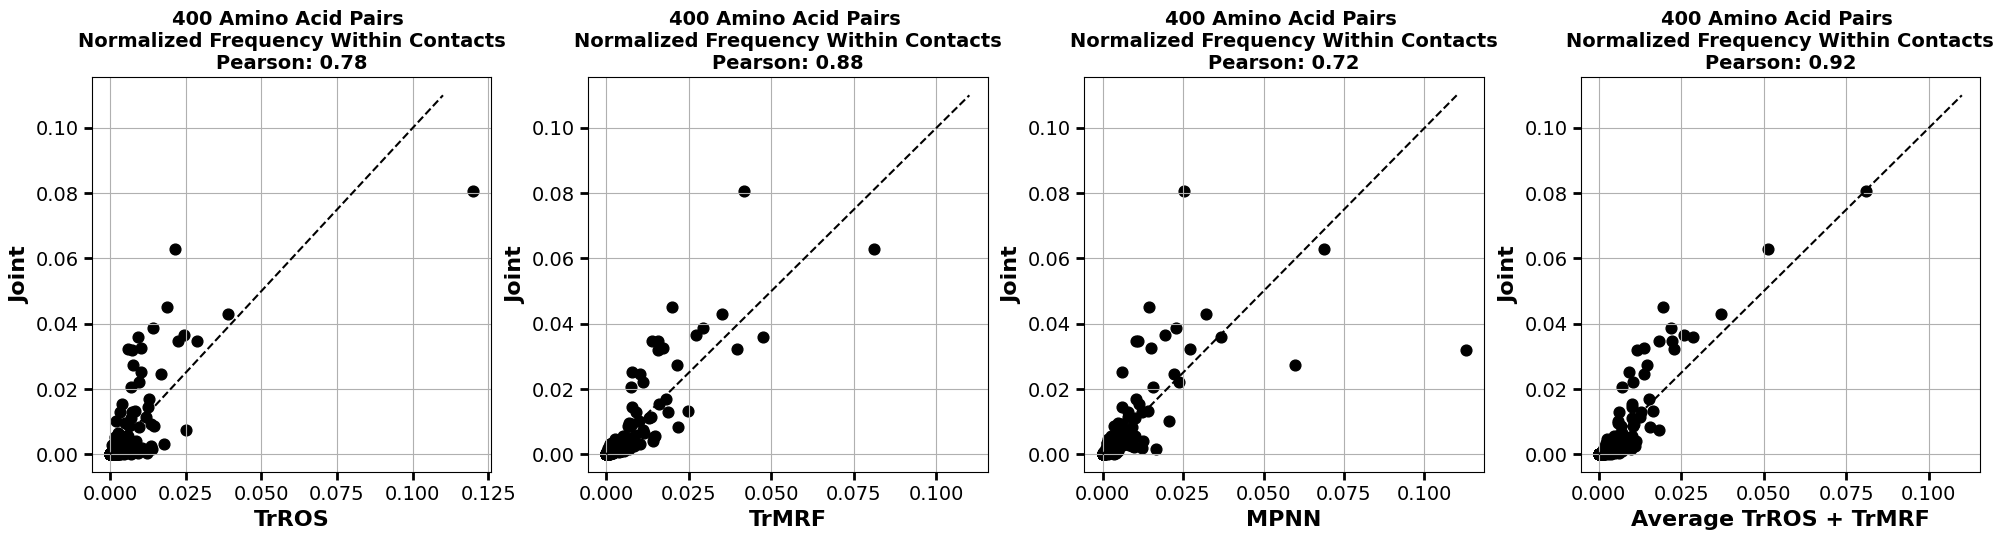

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

A=folded_matrix_1.flatten()/np.sum(folded_matrix_1)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)

min_val = 0
max_val = 0.11

fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))


axes[0].scatter(A, B, color='black' , s = 60)
axes[0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[0].set_title("400 Amino Acid Pairs \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[0].set_xlabel("TrROS",fontsize = 16, weight = "bold")
axes[0].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[0].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[0].grid(True)

A=folded_matrix_2.flatten()/np.sum(folded_matrix_2)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)

axes[1].scatter(A, B, color='black', s = 60)
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[1].set_title("400 Amino Acid Pairs \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[1].set_xlabel("TrMRF",fontsize = 16, weight = "bold")
axes[1].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[1].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[1].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[1].grid(True)



A=folded_matrix_4.flatten()/np.sum(folded_matrix_4)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)



axes[2].scatter(A, B, color='black', s = 60)
axes[2].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[2].set_title("400 Amino Acid Pairs \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[2].set_xlabel("MPNN",fontsize = 16, weight = "bold")
axes[2].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[2].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[2].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[2].grid(True)



A=(folded_matrix_1.flatten()/np.sum(folded_matrix_1) + folded_matrix_2.flatten()/np.sum(folded_matrix_2))/2
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)


axes[3].scatter(A, B, color='black' , s = 60)
axes[3].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[3].set_title("400 Amino Acid Pairs \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[3].set_xlabel("Average TrROS + TrMRF",fontsize = 16, weight = "bold")
axes[3].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[3].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[3].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[3].grid(True)

plt.tight_layout()
plt.savefig('figures/contact_pairs/d<5_counts_diagonal_scatter_plot_retitle.png', dpi=300)

plt.show()

In [90]:
desired_order = 'AFILVMWYDEKRHNQSTGPC'
amino_acid_pairs = []

for i in range(len(desired_order)):
    for j in range(len(desired_order)):
        pair = f"{desired_order[i]}-{desired_order[j]}"
        amino_acid_pairs.append(pair)


def get_amino_acid_pair(index):
    if 0 <= index < len(amino_acid_pairs):
        return amino_acid_pairs[index]
    else:
        return None  

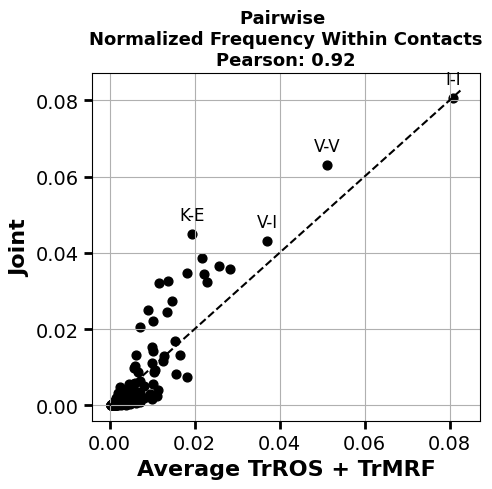

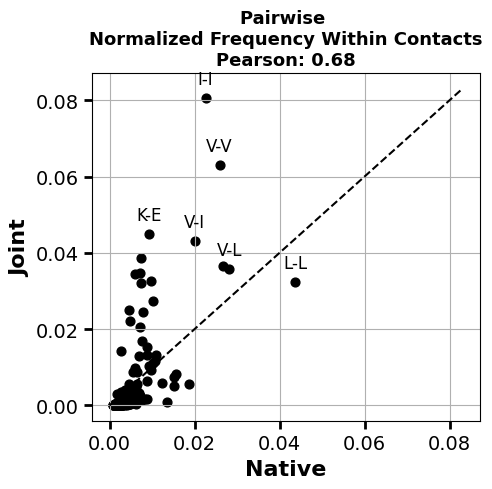

In [152]:
folded_matrix_decoy_native[:,-1] = 0 ## disregard C
folded_matrix_decoy_native[-1,:] = 0 ## disregard C


A = (folded_matrix_1.flatten() / np.sum(folded_matrix_1) + folded_matrix_2.flatten() / np.sum(folded_matrix_2)) / 2
B = folded_matrix_3.flatten() / np.sum(folded_matrix_3)
C = folded_matrix_decoy_native.flatten() / np.sum(folded_matrix_decoy_native)


num_elements = 400
row_indices, col_indices = np.tril_indices(20, k=0)
flat_indices = np.ravel_multi_index((row_indices, col_indices), dims=(20,20))[:-20] ## exclude last 20 which are C
A_filtered, B_filtered, C_filtered = A[flat_indices], B[flat_indices], C[flat_indices]


# Set the minimum and maximum values for the plot
min_val = 0
max_val = 0.083

top_k = 3  # Number of top indices to retrieve from each matrix


top_indices_B = np.argsort(B)[-top_k:]  # Get indices of the top 3 amino acids based on matrix B
top_indices_A = np.argsort(A)[-top_k:]  # Get indices of the top 3 amino acids based on matrix C

combined_top_indices = np.unique(np.concatenate((top_indices_B, top_indices_A)))

top_amino_acids = [get_amino_acid_pair(i) for i in combined_top_indices]  # Convert to amino acid pairs

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(A_filtered, B_filtered, color='black', s=40)
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A_filtered, B_filtered)
spearman_corr, _ = scipy.stats.spearmanr(A_filtered, B_filtered)


ax.set_title(f"Pairwise \nNormalized Frequency Within Contacts\nPearson: {pearson_corr:.2f}", fontsize=13, weight="bold")
ax.set_xlabel("Average TrROS + TrMRF", fontsize=16, weight="bold")
ax.set_ylabel("Joint", fontsize=16, weight="bold")
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
ax.tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
ax.grid(True)

for i in combined_top_indices:
    ax.annotate(top_amino_acids[combined_top_indices.tolist().index(i)], 
                (A[i], B[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center', 
                fontsize=12, 
                color='black')

plt.tight_layout()
plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/d<5_400_amino_acid_pairs_joint.png', dpi=300)
plt.show()



top_indices_B = np.argsort(B)[-4:]  # Get indices of the top 3 amino acids based on matrix B
top_indices_C = np.argsort(C)[-2:]  # Get indices of the top 3 amino acids based on matrix C

combined_top_indices = np.unique(np.concatenate((top_indices_B, top_indices_C)))

top_amino_acids = [get_amino_acid_pair(i) for i in combined_top_indices]  # Convert to amino acid pairs

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(C_filtered, B_filtered, color='black', s=40)
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(C_filtered, B_filtered)
spearman_corr, _ = scipy.stats.spearmanr(C_filtered, B_filtered)

ax.set_title(f"Pairwise \nNormalized Frequency Within Contacts\nPearson: {pearson_corr:.2f}", fontsize=13, weight="bold")
ax.set_xlabel("Native", fontsize=16, weight="bold")
ax.set_ylabel("Joint", fontsize=16, weight="bold")
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
ax.tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
ax.grid(True)

for i in combined_top_indices:
    ax.annotate(top_amino_acids[combined_top_indices.tolist().index(i)], 
                (C[i], B[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center', 
                fontsize=12, 
                color='black')

plt.tight_layout()
plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/native_decoy_vs_d<5_400_amino_acid_pairs_joint.png', dpi=300)
plt.show()

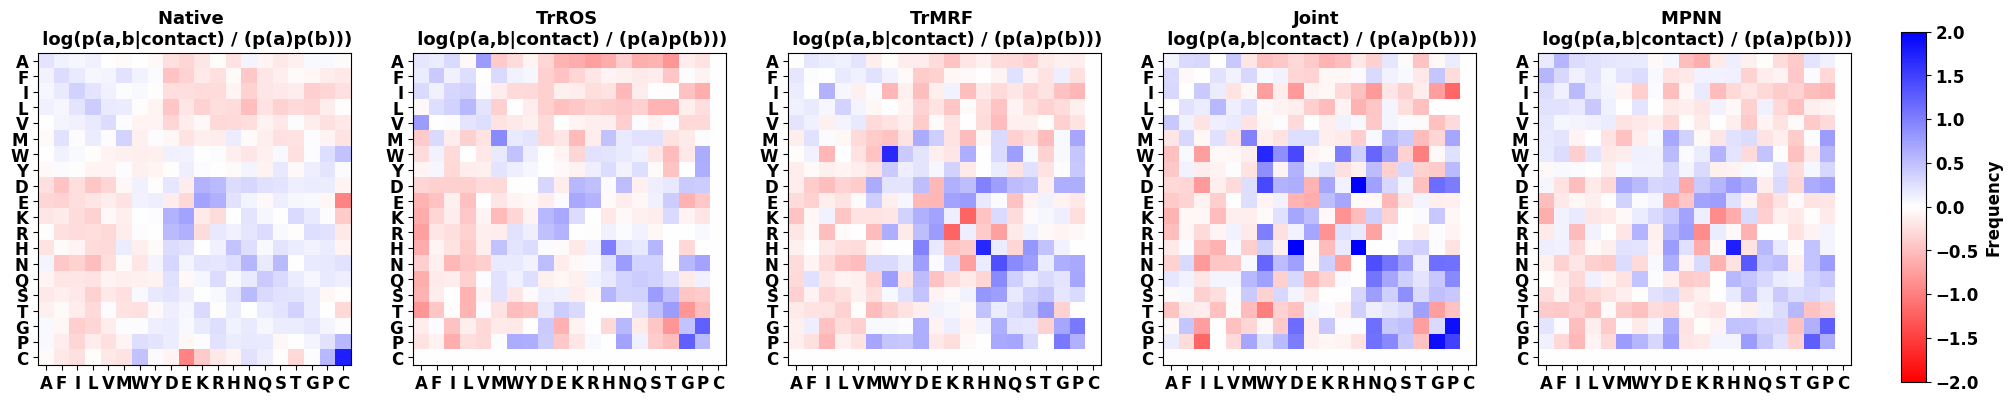

In [44]:
import math 
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'AFILVMWYDEKRHNQSTGPC'

order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

def plot_reordered_prob_matrix(ax,result_matrix, title, colorbar=False):
    
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = (matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]+matrix[order_mapping[desired_order[j]], order_mapping[desired_order[i]]])/2 

            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(reordered_matrix)
    p_a = np.sum(reordered_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(reordered_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(20):
            p_ab_contact = reordered_matrix[i, j]/matrix_sum

            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[i, j] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -2 
    vmax = 2  

    
    img = ax.imshow(contact_matrix, cmap='bwr_r', origin='upper', vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} \n log(p(a,b|contact) / (p(a)p(b)))", fontsize=13, weight='bold')
    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')


    return img

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

img0 = plot_reordered_prob_matrix(axs[0],np.array(np.sum(decoy_native_pairwise_count, axis=0)).reshape(21, 21), "Native")
img1 =plot_reordered_prob_matrix(axs[1],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")
img2= plot_reordered_prob_matrix(axs[2],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")
img3= plot_reordered_prob_matrix(axs[3],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "Joint")
img4= plot_reordered_prob_matrix(axs[4],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN", colorbar=True)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])  
cbar = fig.colorbar(img4, cax=cbar_ax)  
cbar.ax.set_ylabel('Frequency', fontsize=12, weight='bold')
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    l.set_fontsize(12)


plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/log_p_d<5_counts.png', dpi=300)

/tmp/ipykernel_2116285/3449057663.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')


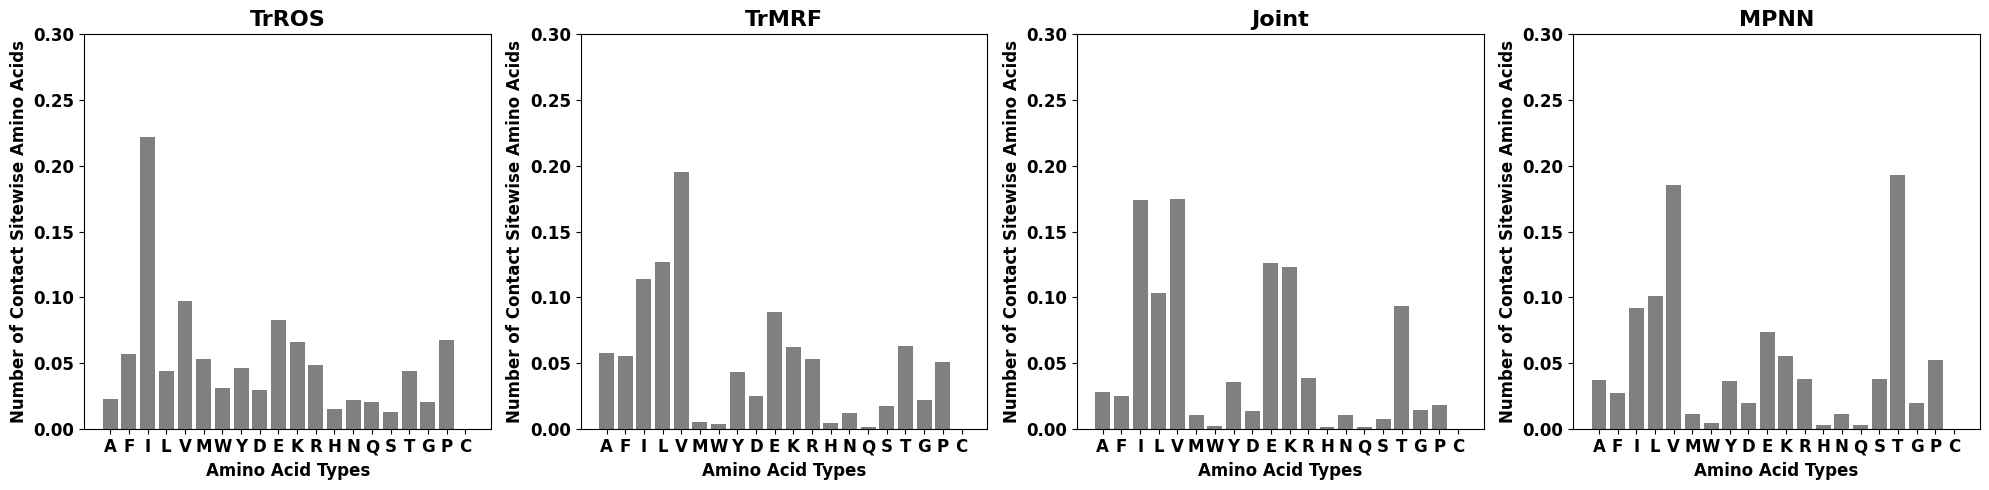

In [127]:
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'AFILVMWYDEKRHNQSTGPC'

order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title,  fontsize=16, weight='bold')
    ax.set_xlabel('Amino Acid Types',  fontsize=12,  weight='bold')
    ax.set_ylabel('Number of Contact Sitewise Amino Acids',  fontsize=12, weight='bold')
    ax.set_ylim([0,0.3])
    ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')

    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        label.set_fontsize(12)
        label.set_fontweight('bold')

    return sitewise_matrix
    
    
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sitewise_matrix_1 = plot_sitewise_subplot(axs[0], np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")
sitewise_matrix_2 = plot_sitewise_subplot(axs[1], np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")
sitewise_matrix_3 =plot_sitewise_subplot(axs[2], np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "Joint")

sitewise_matrix_4 = plot_sitewise_subplot(axs[3], np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")
plt.tight_layout()


# plt.savefig('figures/contact_pairs/d<5_sitwewise_prob.png', dpi=300)
plt.show()

In [141]:
sitewise_decoy_native = plot_sitewise_subplot(axs[0], np.array(np.sum(decoy_native_pairwise_count, axis=0)).reshape(21, 21), "TrROS")

/tmp/ipykernel_2116285/3449057663.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')


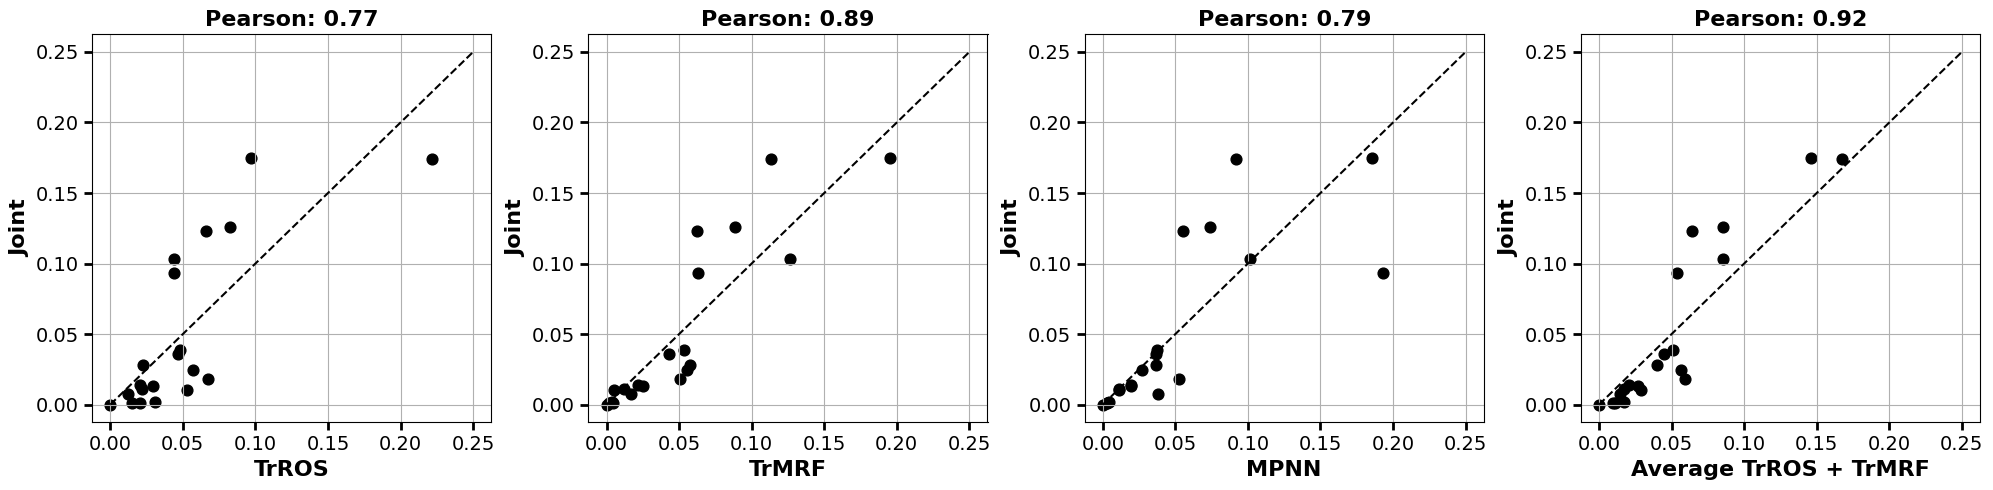

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


A=sitewise_matrix_1
B=sitewise_matrix_3

min_val = 0
max_val = 0.25

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].scatter(A, B, color='black', s =60)
axes[0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[0].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[0].set_xlabel("TrROS",fontsize = 16, weight = "bold")
axes[0].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[0].tick_params(axis='both', which='major', labelsize=14)  
axes[0].tick_params(axis='both', which='major', width=2, length=6) 
axes[0].grid(True)

A=sitewise_matrix_2
B=sitewise_matrix_3



axes[1].scatter(A, B, color='black', s =60)
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--') 


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[1].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[1].set_xlabel("TrMRF",fontsize = 16, weight = "bold")
axes[1].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[1].tick_params(axis='both', which='major', labelsize=14) 
axes[1].tick_params(axis='both', which='major', width=2, length=6)  
axes[1].grid(True)


A=sitewise_matrix_4
B=sitewise_matrix_3



axes[2].scatter(A, B, color='black', s =60)
axes[2].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[2].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[2].set_xlabel("MPNN",fontsize = 16, weight = "bold")
axes[2].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[2].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[2].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[2].grid(True)


A=(sitewise_matrix_1 + sitewise_matrix_2)/2
B=sitewise_matrix_3

axes[3].scatter(A, B, color='black', s =60)
axes[3].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[3].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[3].set_xlabel("Average TrROS + TrMRF",fontsize = 16, weight = "bold")
axes[3].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[3].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[3].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[3].grid(True)

plt.tight_layout()
plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/d<5_sitwewise_counts_scatter.png', dpi=300)

plt.show()

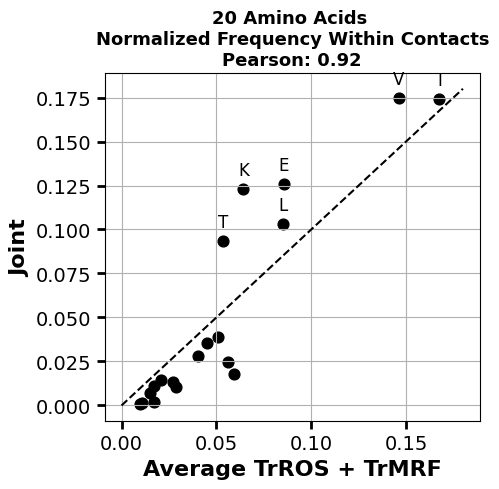

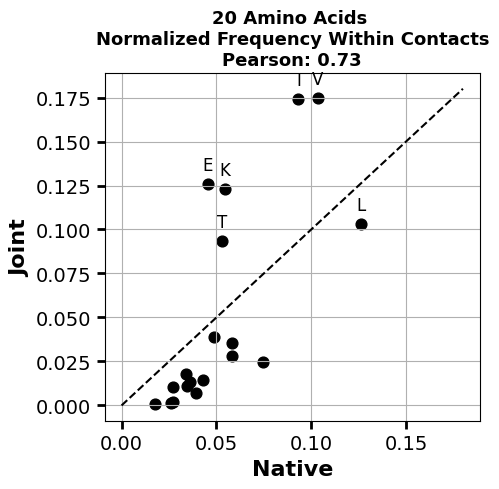

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

A = (sitewise_matrix_1 + sitewise_matrix_2) / 2  # Average of sitewise_matrix_1 and sitewise_matrix_2
B = sitewise_matrix_3

A = A[:-1] 
B = B[:-1]

C = sitewise_decoy_native[:-1]/sum(sitewise_decoy_native[:-1]) ## exclude C
t = 6


top_indices = np.argsort(sitewise_matrix_3)[-t:]   
top_amino_acids = [list('AFILVMWYDEKRHNQSTGPC')[i] for i in top_indices]  

min_val = 0
max_val = 0.18


fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(A, B, color='black', s=60)
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line


pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)

ax.set_title(f"20 Amino Acids \nNormalized Frequency Within Contacts\nPearson: {pearson_corr:.2f}", fontsize=13, weight="bold")
ax.set_xlabel("Average TrROS + TrMRF", fontsize=16, weight="bold")
ax.set_ylabel("Joint", fontsize=16, weight="bold")
ax.tick_params(axis='both', which='major', labelsize=14)  
ax.tick_params(axis='both', which='major', width=2, length=6) 
ax.grid(True)

for i in top_indices:
    ax.annotate(top_amino_acids[top_indices.tolist().index(i)], 
                (A[i], B[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center', 
                fontsize=12, 
                color='black')


plt.tight_layout()
plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/d<5<20_amino_acid_joint.png', dpi=300)
plt.show()


fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(C, B, color='black', s=60)
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(C, B)
spearman_corr, _ = scipy.stats.spearmanr(C, B)

ax.set_title(f"20 Amino Acids \nNormalized Frequency Within Contacts\nPearson: {pearson_corr:.2f}", fontsize=13, weight="bold")
ax.set_xlabel("Native", fontsize=16, weight="bold")
ax.set_ylabel("Joint", fontsize=16, weight="bold")
ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
ax.tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
ax.grid(True)

for i in top_indices:
    ax.annotate(top_amino_acids[top_indices.tolist().index(i)], 
                (C[i], B[i]), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center', 
                fontsize=12, 
                color='black')

plt.tight_layout()
plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/d<5<20_amino_acid_joint_native.png', dpi=300)
plt.show()


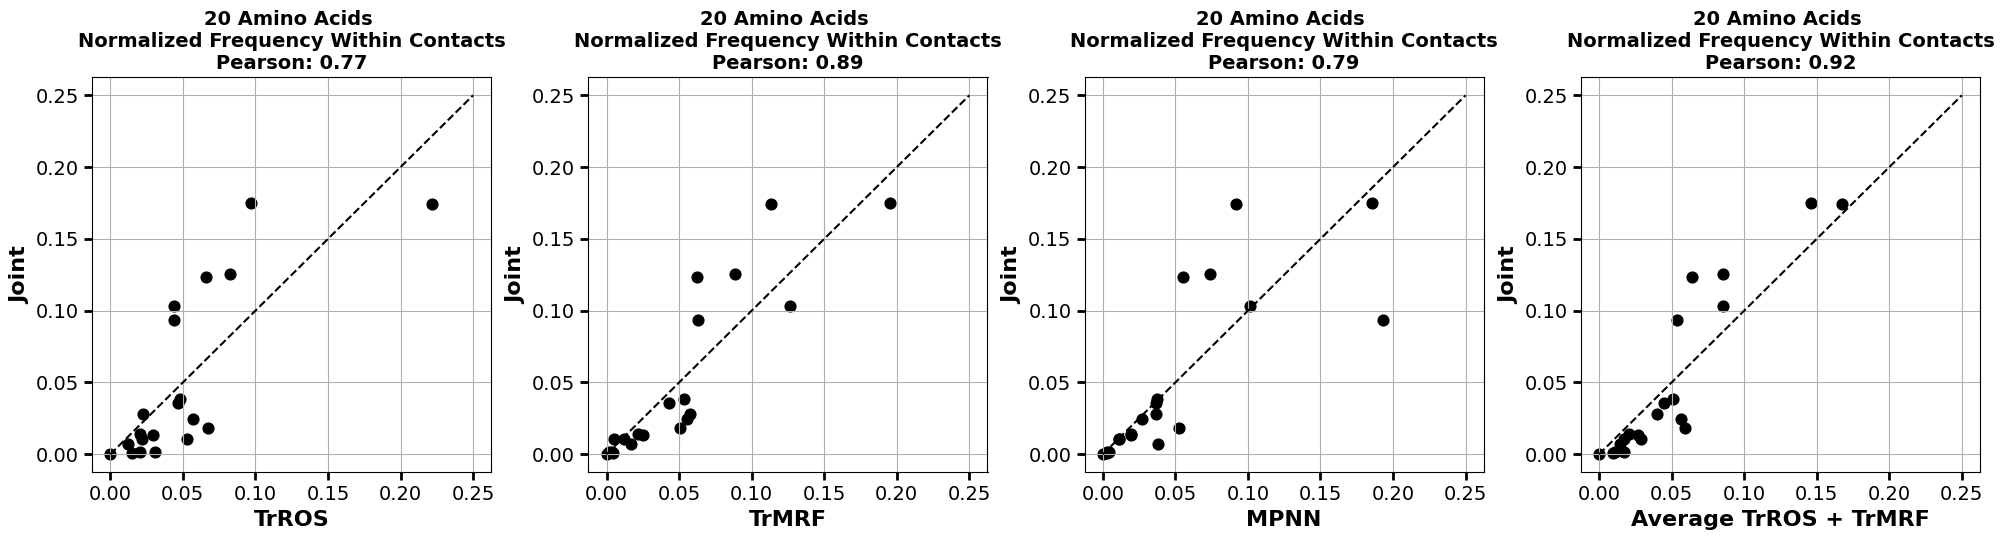

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


A=sitewise_matrix_1
B=sitewise_matrix_3

min_val = 0
max_val = 0.25

fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))

axes[0].scatter(A, B, color='black', s =60)
axes[0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[0].set_title("20 Amino Acids \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[0].set_xlabel("TrROS",fontsize = 16, weight = "bold")
axes[0].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[0].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[0].grid(True)

A=sitewise_matrix_2
B=sitewise_matrix_3


axes[1].scatter(A, B, color='black', s =60)
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[1].set_title("20 Amino Acids \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[1].set_xlabel("TrMRF",fontsize = 16, weight = "bold")
axes[1].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[1].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[1].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[1].grid(True)


A=sitewise_matrix_4
B=sitewise_matrix_3


axes[2].scatter(A, B, color='black', s =60)
axes[2].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line
cient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[2].set_title("20 Amino Acids \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[2].set_xlabel("MPNN",fontsize = 16, weight = "bold")
axes[2].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[2].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[2].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[2].grid(True)


A=(sitewise_matrix_1 + sitewise_matrix_2)/2
B=sitewise_matrix_3


axes[3].scatter(A, B, color='black', s =60)
axes[3].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[3].set_title("20 Amino Acids \nNormalized Frequency Within Contacts\nPearson: {:.2f}".format(pearson_corr), fontsize = 14, weight = "bold")
axes[3].set_xlabel("Average TrROS + TrMRF",fontsize = 16, weight = "bold")
axes[3].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[3].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[3].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[3].grid(True)


plt.tight_layout()
plt.savefig('/home/jupyter-yehlin/DMSV2/final_paper_figures/d<5_sitwewise_counts_scatter_retitle.png', dpi=300)

plt.show()